# Stock Market Time Series Analysis

#### The goal of this notebook is to develop multiple Deep Learnign based models for forcasting stock prices of multiple companies  

## Tesla Stock

#### The dataset contains the tesla stock prices for last 10 years.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPooling1D, TimeDistributed, LSTM

In [2]:
# Read in data
tesla_df = pd.read_csv('TSLA.csv')

In [3]:
# Basic info about dataset
tesla_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.2+ KB


In [4]:
tesla_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [5]:
tesla_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300
2415,2020-02-03,673.690002,786.140015,673.520020,780.000000,780.000000,47065000


In [6]:
# Create a new colmn for Year
tesla_df['Year'] = pd.DatetimeIndex(tesla_df['Date']).year

Text(0.5, 1.0, 'Time Series Data - TSLA - 2010 to 2020')

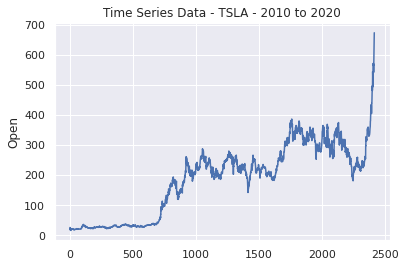

In [7]:
# Plot the data
sns.set(style='darkgrid')
sns.lineplot(y=tesla_df['Open'], x=tesla_df.index).set_title("Time Series Data - TSLA - 2010 to 2020")

#### Initialy there is no movement in the data i.e the data is linear. We will filter out data leass than 2015

In [8]:
tesla_df = tesla_df[tesla_df['Year'] >= 2015]

Text(0.5, 1.0, 'Time Series Data - TSLA - 2015 to 2020')

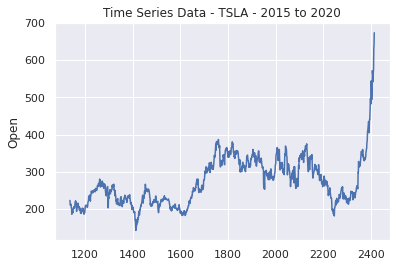

In [9]:
# Plot the data
sns.set(style='darkgrid')
sns.lineplot(y=tesla_df['Open'], x=tesla_df.index).set_title("Time Series Data - TSLA - 2015 to 2020")

In [10]:
tesla_df['Open'].describe()

count    1280.000000
mean      273.292586
std        65.678217
min       142.320007
25%       222.215003
50%       259.619995
75%       318.000000
max       673.690002
Name: Open, dtype: float64

#### Now, we will transform the data so that all the values are on the same scale.

In [11]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))

In [12]:
# We will use the resulting scaled dataset for future operations in the notebook as well as model training
scaled_tesla_df = min_max_scaler.fit_transform(np.array(tesla_df['Open']).reshape(-1,1))
scaled_tesla_df

array([[0.15158927],
       [0.13593164],
       [0.12748178],
       ...,
       [0.9223328 ],
       [0.93659785],
       [1.        ]])

In [13]:
#### Split our data in train and test. Note how it is different from non time series dataset
def ts_train_test_split(data, train_size_prop):
    if type(train_size_prop) == int:
        print('Error: Value not float')
    if train_size_prop > 1.0 or train_size_prop < 0.0:
        print('Error:Value shoud be between 0 and 1')
    train_size = int(len(data) * train_size_prop)
    test_size = 1 - train_size
    train_data = data[:train_size,:]
    test_data = data[train_size:len(data),:]
    return train_data, test_data

In [14]:
train_data, test_data = ts_train_test_split(scaled_tesla_df, 0.7)

In [15]:
train_data.shape

(896, 1)

In [16]:
test_data.shape

(384, 1)

#### The next step is to transform our data so that it can be fed into deep learning models

In [17]:
def prepare_data_for_deep_learning_models(data, tsteps=1):
    X, y = [], []
    for i in range(len(data)-tsteps-1):
        row = data[i:(i+tsteps), 0] 
        X.append(row)
        y.append(data[i + tsteps, 0])
    return np.array(X), np.array(y)

In [18]:
time_step = 100
X_train, y_train = prepare_data_for_deep_learning_models(train_data, time_step)
X_test, y_test = prepare_data_for_deep_learning_models(test_data, time_step)

In [19]:
print(f' X Train: {X_train.shape}')
print(f' y Train: {y_train.shape}')
print(f' X Test: {X_test.shape}')
print(f' y Test: {y_test.shape}')

X Train: (795, 100)
 y Train: (795,)
 X Test: (283, 100)
 y Test: (283,)


#### We will create three models
#### 1) LSTM
#### 2) CNN
#### 3) CNN-LSTM

In [20]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Using TensorFlow backend.


#### <u>LSTM</u>

In [21]:
# For LSTM -> We have to reshape our data into 3D. (samples, time_steps, features)
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [22]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True, input_shape=(100,1)))
model_lstm.add(LSTM(100, return_sequences=True))
model_lstm.add(LSTM(100, ))
model_lstm.add(Dense(1))
model_lstm.compile(loss=root_mean_squared_error, optimizer='adam')

In [23]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_lstm.fit(X_train_lstm, y_train, validation_data=(X_test_lstm, y_test),epochs=100, batch_size=64, verbose=1)

Epoch 1/100
13/13 [==============================] - 7s 529ms/step - loss: 0.0897 - val_loss: 0.0656
Epoch 2/100
13/13 [==============================] - 6s 434ms/step - loss: 0.0398 - val_loss: 0.0554
Epoch 3/100
13/13 [==============================] - 5s 412ms/step - loss: 0.0353 - val_loss: 0.0528
Epoch 4/100
13/13 [==============================] - 5s 405ms/step - loss: 0.0327 - val_loss: 0.0482
Epoch 5/100
13/13 [==============================] - 5s 403ms/step - loss: 0.0325 - val_loss: 0.0450
Epoch 6/100
13/13 [==============================] - 5s 412ms/step - loss: 0.0324 - val_loss: 0.0418
Epoch 7/100
13/13 [==============================] - 5s 402ms/step - loss: 0.0283 - val_loss: 0.0403
Epoch 8/100
13/13 [==============================] - 5s 407ms/step - loss: 0.0270 - val_loss: 0.0374
Epoch 9/100
13/13 [==============================] - 5s 406ms/step - loss: 0.0257 - val_loss: 0.0386
Epoch 10/100
13/13 [==============================] - 6s 423ms/step - loss: 0.0255 - val_lo

#### <u>CNN</u>

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', input_shape=(time_step, 1)))
model_cnn.add(MaxPooling1D())
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(time_step, 1)))
model_cnn.add(MaxPooling1D())
model_cnn.add(Conv1D(filters=256, kernel_size=5, activation='relu', padding='same', input_shape=(time_step, 1)))
model_cnn.add(MaxPooling1D())
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss=root_mean_squared_error, optimizer='adam')


In [ ]:
model_cnn.summary()

In [27]:
X_train_cnn, X_test_cnn = X_train_lstm.copy(), X_test_lstm.copy()

In [28]:
model_cnn.fit(X_train_cnn, y_train, validation_data=(X_test_cnn, y_test),epochs=100, batch_size=64, verbose=1)

Epoch 1/100
13/13 [==============================] - 1s 68ms/step - loss: 0.0801 - val_loss: 0.0863
Epoch 2/100
13/13 [==============================] - 1s 61ms/step - loss: 0.0406 - val_loss: 0.0465
Epoch 3/100
13/13 [==============================] - 1s 62ms/step - loss: 0.0367 - val_loss: 0.0535
Epoch 4/100
13/13 [==============================] - 1s 61ms/step - loss: 0.0298 - val_loss: 0.0306
Epoch 5/100
13/13 [==============================] - 1s 63ms/step - loss: 0.0259 - val_loss: 0.0281
Epoch 6/100
13/13 [==============================] - 1s 58ms/step - loss: 0.0194 - val_loss: 0.0247
Epoch 7/100
13/13 [==============================] - 1s 58ms/step - loss: 0.0167 - val_loss: 0.0229
Epoch 8/100
13/13 [==============================] - 1s 64ms/step - loss: 0.0147 - val_loss: 0.0226
Epoch 9/100
13/13 [==============================] - 1s 57ms/step - loss: 0.0145 - val_loss: 0.0207
Epoch 10/100
13/13 [==============================] - 1s 61ms/step - loss: 0.0144 - val_loss: 0.0212

KeyboardInterrupt: 

#### <u>CNN-LSTM</u>

In [ ]:
# For CNN-LSTM -> We have to reshape our data into 3D. (samples, subsequences, timesteps, features)
# 100 -> n * m
# in our case 10 * 10
# This is done because we will be using a time distributed
X_train_cnn_lstm = X_train.reshape(X_train.shape[0], 10, 10, 1)
X_test_cnn_lstm = X_test.reshape(X_test.shape[0], 10, 10, 1)

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', padding='same',), input_shape=(None, 10, 1)))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(100, return_sequences=True, activation='relu'))
model_cnn_lstm.add(LSTM(100, return_sequences=True, activation='relu'))
model_cnn_lstm.add(LSTM(100, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(optimizer='adam', loss=root_mean_squared_error)

In [ ]:
model_cnn_lstm.summary()

In [ ]:
model_cnn_lstm.fit(X_train_cnn_lstm, y_train, validation_data=(X_test_cnn_lstm, y_test),epochs=100, batch_size=64, verbose=1)

#### Model Results

In [32]:
from sklearn.metrics import mean_squared_error
import math
inv_y_train =min_max_scaler.inverse_transform(y_train.reshape(-1,1))
inv_y_test =min_max_scaler.inverse_transform(y_test.reshape(-1,1))

In [33]:
# LSTM Model Predictions
lstm_train_pred = min_max_scaler.inverse_transform(model_lstm.predict(X_train_lstm))
lstm_test_pred = min_max_scaler.inverse_transform(model_lstm.predict(X_test_lstm))

In [34]:
# CNN Model Predictions
cnn_train_pred = min_max_scaler.inverse_transform(model_cnn.predict(X_train_cnn))
cnn_test_pred = min_max_scaler.inverse_transform(model_cnn.predict(X_test_cnn))

In [35]:
# CNN-LSTM Model Predictions
cnn_lstm_train_pred = min_max_scaler.inverse_transform(model_cnn_lstm.predict(X_train_cnn_lstm))
cnn_lstm_test_pred = min_max_scaler.inverse_transform(model_cnn_lstm.predict(X_test_cnn_lstm))

In [36]:
print(f'''
************************** LSTM Model ****************************
Train MSE : {mean_squared_error(y_train, lstm_train_pred)}
Train RMSE : {math.sqrt(mean_squared_error(inv_y_train, lstm_train_pred))}
Test MSE : {mean_squared_error(inv_y_test, lstm_test_pred)}
Test RMSE : {math.sqrt(mean_squared_error(inv_y_test, lstm_test_pred))}
************************** CNN Model *****************************
Train MSE : {mean_squared_error(inv_y_train, cnn_train_pred)}
Train RMSE : {math.sqrt(mean_squared_error(inv_y_train, cnn_train_pred))}
Test MSE : {mean_squared_error(inv_y_test, cnn_test_pred)}
Test RMSE : {math.sqrt(mean_squared_error(inv_y_test, cnn_test_pred))}************************** CNN-LSTM Model ************************
Train MSE : {mean_squared_error(inv_y_train, cnn_lstm_train_pred)}
Train RMSE : {math.sqrt(mean_squared_error(inv_y_train, cnn_lstm_train_pred))}
Test MSE : {mean_squared_error(inv_y_test, cnn_lstm_test_pred)}
Test RMSE : {math.sqrt(mean_squared_error(inv_y_test, cnn_lstm_test_pred))}
''')


************************** LSTM Model ****************************
Train MSE : 73849.83950045606
Train RMSE : 7.446524914652238
Test MSE : 178.85646686886707
Test RMSE : 13.373722999556522
************************** CNN Model *****************************
Train MSE : 37.11379731200213
Train RMSE : 6.0921094304027505
Test MSE : 167.90920640764224
Test RMSE : 12.957978484611026************************** CNN-LSTM Model ************************
Train MSE : 166.95440767254868
Train RMSE : 12.921083842795413
Test MSE : 1439.7761051737616
Test RMSE : 37.944381733976925



In [ ]:
#### The LSTM model performs the best but CNN performs faster predictions. The stacked model has the worst score.

#### Save the sclaer and the models

In [ ]:
import pickle
with open('min_max_scaler_TSLA.h5', 'wb') as f:
    pickle.dump(min_max_scaler, f)

In [ ]:
model_lstm.save('model_tesla_lstm.h5')
model_cnn.save('model_tesla_cnn.h5')
model_cnn_lstm.save('model_tesla_cnn_lstm.h5')

In [ ]:
# Define a Function to prepare the data for next n days

def predict_prices_for_n_days():
    pass